# Train Nothing, Label Everything: Zero-Shot Text Classification with Explainability

In a world full of unstructured text—tweets, support tickets, research abstracts, news articles—automated text classification is both essential and challenging. Traditionally, models required large amounts of labeled data and extensive retraining for each new task.

**Zero-shot learning** offers a smarter solution. Instead of training on labeled examples, we simply define what we’re looking for in plain language—and let the model infer the rest. With the power of modern **pretrained transformer models**, this becomes not only possible but surprisingly effective.

In this notebook, you'll explore how to:
- Perform **zero-shot classification** using [`facebook/bart-large-mnli`](https://huggingface.co/facebook/bart-large-mnli) via the **Hugging Face 🤗 Transformers** library.
- Accept flexible user-defined labels and score them by **confidence**.
- Visualize top predictions with lightweight **matplotlib** charts.
- Generate natural-language **explanations** for predictions using an open-source **LLM**: [`tiiuae/falcon-rw-1b`](https://huggingface.co/tiiuae/falcon-rw-1b).

No fine-tuning. No training loops. Just smart generalization from models that already understand language.


## Install and Import Required Libraries

We’ll be using the following:

- **Transformers** by [🤗 Hugging Face](https://huggingface.co/docs/transformers): A powerful library for using pretrained language models like `facebook/bart-large-mnli`.
- **Torch (PyTorch)**: The underlying framework used for running transformer models.
- **Accelerate** (optional): Helps run models on CPU/GPU efficiently.
- **IPywidgets** (optional): For adding interactivity later, like dropdowns or sliders.

We’ll also check if GPU is available to speed up inference.

📚 Refer:
- 🤗 Transformers: https://huggingface.co/docs/transformers
- PyTorch: https://pytorch.org/


In [ ]:
# Install required packages
!pip install -q transformers accelerate ipywidgets

# Importing required modules
from transformers import pipeline
import torch

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.2 MB/s eta 0:00:00
Using device: cpu


## Load the Zero-Shot Classification Pipeline

We’ll now load a **zero-shot text classification pipeline** from Hugging Face Transformers.

### Why `facebook/bart-large-mnli`?
We’re using the model `facebook/bart-large-mnli`, which is pre-trained on the **Multi-Genre Natural Language Inference (MNLI)** task. It can reason whether a given **hypothesis** (label) is *entailed* by a given **premise** (text).

This makes it ideal for **zero-shot classification**, where we treat:
- **Text** → as the *premise*
- **Candidate labels** → as *hypotheses*

🔗 Refer:
- BART Model: https://huggingface.co/facebook/bart-large-mnli
- Zero-shot pipeline docs: https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.ZeroShotClassificationPipeline


In [ ]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=0 if device == "cuda" else -1)

print("Model loaded successfully!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Model loaded successfully!


## Run Basic Zero-Shot Text Classification

Now let’s test the model using a **custom input sentence** and a few **user-defined labels**.

You simply provide:
- A text input (e.g., a news headline or product review)
- A list of candidate labels (e.g., `"sports"`, `"politics"`, `"entertainment"`)

The model will then predict **how likely each label is** for the given text — without ever having seen those labels during training!

Let’s see it in action.


In [ ]:
# Sample text and labels
text = "The stock market saw record gains this week as tech shares surged."
candidate_labels = ["finance", "technology", "sports", "entertainment"]

# Run zero-shot classification
result = classifier(text, candidate_labels)

# Display results
for label, score in zip(result['labels'], result['scores']):
    print(f"{label:<15} --> Confidence: {score:.4f}")


technology      --> Confidence: 0.9767
finance         --> Confidence: 0.0137
entertainment   --> Confidence: 0.0064
sports          --> Confidence: 0.0032


### Visualize Prediction Confidence

To make the model's predictions easier to interpret, we’ll generate a simple horizontal **bar chart** that shows the **confidence scores for the top 3 predicted labels**.

This is helpful in understanding how confidently the model chooses one label over others, especially when predictions are close.



1. "NASA is planning its next mission to Mars."
   → space           0.93
   → technology      0.06
   → finance         0.00


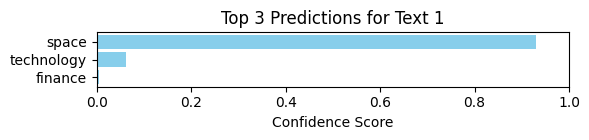


2. "The new iPhone features an advanced AI chip."
   → technology      0.99
   → space           0.01
   → sports          0.00


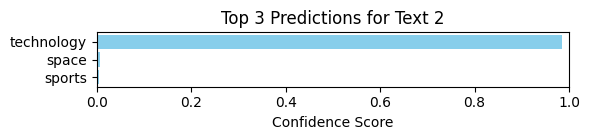


3. "Lionel Messi scored a stunning goal in last night’s match."
   → sports          0.90
   → space           0.05
   → technology      0.04


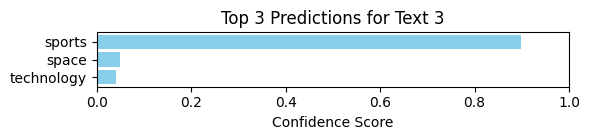


4. "Cryptocurrency prices continue to fall in global markets."
   → technology      0.49
   → finance         0.42
   → space           0.07


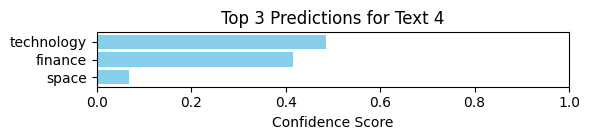

In [ ]:
import matplotlib.pyplot as plt

# Multiple test texts for batch classification
texts = [
    "NASA is planning its next mission to Mars.",
    "The new iPhone features an advanced AI chip.",
    "Lionel Messi scored a stunning goal in last night’s match.",
    "Cryptocurrency prices continue to fall in global markets."
]

candidate_labels = ["sports", "space", "technology", "finance"]

# Classify all texts
batch_results = classifier(texts, candidate_labels)

# Visualize top 3 predictions for each input
for i, result in enumerate(batch_results):
    text = texts[i]
    labels_scores = list(zip(result['labels'], result['scores']))
    top3 = labels_scores[:3]

    print(f"\n{i+1}. \"{text}\"")
    for label, score in top3:
        print(f"   → {label:15} {score:.2f}")

    # Bar chart for top 3 scores
    labels, scores = zip(*top3)
    plt.figure(figsize=(6, 1.5))
    plt.barh(labels, scores, color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f"Top 3 Predictions for Text {i+1}")
    plt.xlabel("Confidence Score")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


## Try It Yourself — Classify Your Own Text!

Want to see how well zero-shot classification works on your own examples?  
In this interactive section, you can input:

- Any **custom sentence or paragraph**
- A list of **labels (topics/categories)** you'd like the model to consider

The model will return which label it thinks fits best — along with a confidence score.

This makes it easy to prototype your own tagging or classification logic without training any models!


In [ ]:
# Input: User-provided text and labels
text_input = input("Enter the text to classify:\n")
labels_input = input("Enter comma-separated candidate labels (e.g., tech, sports, finance):\n")

# Process label list
candidate_labels = [label.strip() for label in labels_input.split(",") if label.strip()]

# Classify using zero-shot model
result = classifier(text_input, candidate_labels)

# Show predictions
print(f"\nText: \"{text_input}\"")
for label, score in zip(result['labels'], result['scores']):
    print(f"→ {label:15} {score:.2f}")


Enter the text to classify:
A new drug trial shows promising results in treating early-stage Alzheimer's disease.
Enter comma-separated candidate labels (e.g., tech, sports, finance):
technology, finance, health, sports, politics

Text: "A new drug trial shows promising results in treating early-stage Alzheimer's disease."
→ health          0.60
→ technology      0.34
→ finance         0.02
→ sports          0.02
→ politics        0.01


The model understands the context of "drug trial" and "Alzheimer's disease" and maps it correctly to the health category — without any prior training on your labels.

"Technology" gets the second-highest score, which is reasonable because medical research often overlaps with tech.

Labels like finance, sports, and politics are rightly ranked much lower.

## Label Explanation with a LLM

In this step, we'll generate a natural-language explanation for **why** a predicted label fits a given input text. We’ll use a free instruction-following model from Hugging Face.

We'll use the [`tiiuae/falcon-rw-1b`](https://huggingface.co/tiiuae/falcon-rw-1b) model — a lightweight open-source language model capable of basic reasoning and instruction following.

We'll form a prompt like:
> **"Explain why this text might belong to the label: 'health'..."**

Then generate a short response using Hugging Face's `pipeline()` interface.


In [ ]:
from transformers import pipeline

# Load a free instruction-following LLM
generator = pipeline("text-generation", model="tiiuae/falcon-rw-1b")

# Define text and label
text = "A new drug trial shows promising results in treating early-stage Alzheimer's disease."
label = "health"

# Craft prompt
prompt = f"Explain in 1-2 sentences why this text might belong to the label: '{label}'.\n\nText: {text}\nExplanation:"

# Generate explanation
response = generator(prompt, max_new_tokens=60, do_sample=True, temperature=0.7)
print(response[0]['generated_text'].replace(prompt, "").strip())


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The text is a new drug trial showing promising results in treating early-stage Alzheimer's disease, which is a type of dementia. The disease starts with memory loss and gradually gets worse until death. This study is a phase 1, 2,3 clinical trial that is testing the safety and efficacy of treating


## Conclusion: Smarter Classification, Less Effort

Zero-shot text classification represents a fundamental shift in how we approach language tasks. Instead of hand-labeling data or retraining models for every new use case, we can now **leverage general-purpose language models** to classify text on the fly—using just natural language labels.

In this notebook, you saw how to:
- Use the **`facebook/bart-large-mnli`** transformer model to classify any input text against arbitrary label sets.
- Visualize confidence scores and predictions to better understand the model’s output.
- Enhance transparency by generating **explanations** using a lightweight **open-source LLM**.

This approach is highly adaptable, scalable, and ideal for rapid prototyping or handling dynamic, evolving taxonomies.

As language models continue to improve, zero-shot techniques like these will become foundational tools for modern NLP workflows.

Want to go further?
- Try with multilingual text or domain-specific data.
- Use richer label descriptions or multi-label settings.
- Integrate with tools like [Label Studio](https://labelstud.io/) for human-in-the-loop refinement.

**Train nothing. Label everything. That’s the future.**
